In [1]:
# Install pydicom for reading .DICOM files
!pip install pydicom

     |████████████████████████████████| 7.1MB 3.5MB/s 


In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import pydicom
import pylab
from skimage.transform import resize
import pathlib
import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
# mount the drive for accessing the image files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set the path for training images
TRAIN_IMAGES ='/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_images'
Dataset = '/content/drive/My Drive/GL Capstone Project/Dataset'
weights = '/content/drive/My Drive/GL Capstone Project/Code Base/Model/ChexNet/Weights/'

In [0]:
import h5py

def read_hdf5(path):

    weights = {}
    
    keys = []
    with h5py.File(path, 'r') as f: # open file
        f.visit(keys.append) # append all keys to list
        for key in keys:
            if ':' in key: # contains data if ':' in key
                #print(f[key].name)
                weights[f[key].name] = f[key].value
    return weights

In [0]:
chex_weight=read_hdf5(weights+"brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [11]:
len(chex_weight.keys())

606

In [0]:
#file = pathlib.Path(TRAIN_IMAGES+"/"+"0e1a2d64-c6fd-4b32-946c-b02a2d575c63.dcm")
#if file.exists ():
#    print ("File exist")
##else:
#    print ("File not exist")

In [0]:
# Read the training CSV File and remove duplicates on Patient Id
filepath = (Dataset+'/stage_2_train_labels.csv')
Images_df = pd.read_csv(filepath)
Images_model_df = Images_df[['patientId','Target']]
Images_model_df=Images_model_df.drop_duplicates(subset='patientId')

In [0]:
# Sample the training images for initial experimentation
Images_sample_df = Images_model_df.sample(frac=0.05,random_state=42)

In [64]:
# Get the count
Images_sample_df['Target'].value_counts()

0    1051
1     283
Name: Target, dtype: int64

In [0]:
# Split into train and test validation datasets
train_df, test_df = train_test_split(Images_sample_df, test_size=0.2, random_state=42, stratify=Images_sample_df[['Target']])

In [0]:
# Convert to dictionary with patient-id as key and target as value
train_dict=train_df.set_index('patientId')['Target'].to_dict()
test_dict=test_df.set_index('patientId')['Target'].to_dict()

In [0]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
#your_module = drive.CreateFile({'id':'185RGsTqpjcdKK2afnDs5LVxIZW6GTQZj'})
#your_module.GetContentFile('generator.py')

In [0]:
# Define Custom Generator Class
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path,batch_size=128, dim=(224,224), n_channels=3,
                 n_classes=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path = path
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dcm_file_sample = (self.path +"/"+ ID +".dcm")
            dcm_data_sample = pydicom.filereader.dcmread(dcm_file_sample)
            image = dcm_data_sample.pixel_array
            image_array = np.stack([image] * 3, axis=2)
            image_array = image_array / 255.
            image_array = resize(image_array, (224, 224), mode= 'constant', anti_aliasing=True)
            X[i,] = image_array

            # Store class
            y[i] = self.labels[ID]

        return X,y

In [0]:
from keras.models import load_model

In [25]:
model = load_model(weights+"brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

ValueError: ignored

In [0]:
# Define the DenseNet model pre-loaded with imagenet weights
input_shape = (224, 224, 3)
num_of_class=1
img_in = Input(input_shape)              
model = DenseNet121(include_top= False , 
                weights='imagenet',      
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

x = model.output  
predictions = Dense(14, activation="sigmoid", name="predictions")(x)    
model = Model(inputs=img_in, outputs=predictions)

In [0]:
model.load_weights(weights+"brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [48]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [49]:
model.layers.pop()
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [0]:
new_layer = Dense(1, activation="sigmoid", name="my_predictions")    
inp = model.input
out = new_layer(model.layers[-1].output)
model2 = Model(inp, out)

In [53]:
model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [0]:
# Create Train and Test generator
train_generator = DataGenerator(list(train_dict.keys()), train_dict,path=TRAIN_IMAGES,batch_size=32)
validation_generator = DataGenerator(list(test_dict.keys()), test_dict,path=TRAIN_IMAGES,batch_size=1)

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=5,),
                  ModelCheckpoint(filepath=weights+'my_model.h5',monitor='val_loss',save_best_only=True,),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,)]

In [0]:
model2.trainable = True

set_trainable = False
for layer in model2.layers:
  #print(layer.name)
  if layer.name == 'my_predictions':
     set_trainable = True
  if set_trainable:
     layer.trainable = True
  else:
     layer.trainable = False

In [0]:
model.load_weights(weights+'my_model.h5')

In [59]:
# Compile with binary cross entropy loss
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [68]:
history=model2.fit_generator(generator=train_generator,
                    epochs=2,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/2
133/133 [==============================] - 5479s 41s/step - loss: 0.3710 - acc: 0.8205 - f1_m: 0.5256 - precision_m: 0.5927 - recall_m: 0.5070 - val_loss: 0.3719 - val_acc: 0.8380 - val_f1_m: 0.0927 - val_precision_m: 0.0927 - val_recall_m: 0.0927
Epoch 2/2
133/133 [==============================] - 5366s 40s/step - loss: 0.3094 - acc: 0.8571 - f1_m: 0.6700 - precision_m: 0.7060 - recall_m: 0.6797 - val_loss: 0.5228 - val_acc: 0.8212 - val_f1_m: 0.0684 - val_precision_m: 0.0684 - val_recall_m: 0.0684


In [60]:
model2.evaluate_generator(validation_generator)

[0.9124552886026183,
 0.2303370786516854,
 0.23033703746420614,
 0.2303370511933659,
 0.2303370511933659]

In [0]:
history.history['val_acc']

NameError: ignored

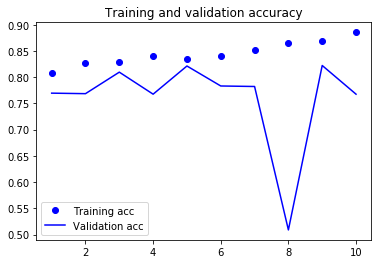

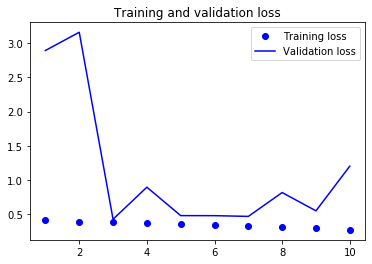

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()